In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#The process of face recognition is divided into the following steps:

1. Detect the face in the image using the mtcnn face detector
2. Feed the detected faces to FaceNet model and obtain the embeddings for the faces(embeddings are 128-dimensional vectors encoding info of the faces in the image).
3. Feed the embeddings to an SVM classifier determine the identity of the detected face

Please note that:
- **This note book is used for development purposes. The SVM model that is trained in this notebook will be saved and used for the final face recognition system deployed to AWS EC2 instance.**
- The model is trained on a set of movie characters. If you want to recognize your face, you should replace the images with a data set of your images and retrain the SVM model.


In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 6.8 MB/s 


In [25]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import mtcnn
from mtcnn import MTCNN
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.metrics import accuracy_score
from matplotlib.patches import Rectangle
import pickle

# Face Detection:

In this step the faces are detected using mtcnn model and by using the returned bounding boxes, faces are cropped. Next, these face images are resized to 160 x 160 as the input image of the facenet model shoud be of (160,160,3) dimensions.

In [ ]:
def face_detection(img_path):
  faces=[]
  boxes_properties=[]
  img = cv2.imread(img_path,1) # 1:Loads a color image
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  detector=MTCNN()
  results = detector.detect_faces(img)# "results" is a list of all bounding boxes surrounding faces in the image, each element of the list is a 
  #library indicating some information about the bounding box. It includes the coordinates of the bottom-left corner of the bounding box,width, and heigh
  for result in results:
    x1, y1, width, height = result['box']
    x1, y1 = abs(x1), abs(y1) # fix the bug when x1 or y1 are negative!
    x2, y2 = x1 + width, y1 + height
    boxes_properties.append([x1,y1,width,height])
    face = img[y1:y2, x1:x2]
    face = cv2.resize(face, (160,160))
    faces.append(face) 
  return faces,boxes_properties

#load_faces function:

This function loads the images and extracts faces for all the images in the specified directory.

In [ ]:
def load_faces(directory):
  faces=[]
  # enumerate files
  for filename in listdir(directory):
    path=directory+'/'+filename
    face=face_detection(path)[0][0]
    faces.append(face)
  return faces

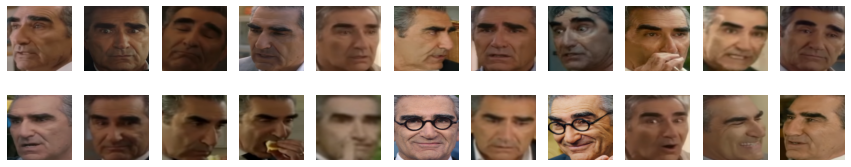

In [ ]:
out=load_faces('/content/drive/MyDrive/face_recognition/Schitts_creek_5_characters/train/Johnny')
plt.figure(figsize=(15,3))
for i in range(1,23):# there are 22 images of Alexis in train/Alexis folder and I want to display all of them.
  plt.subplot(2,11,i)
  plt.axis('off') 
  plt.imshow(out[i-1])


#load_dataset function:

The load_dataset() function expects a directory structures as below:
directory
``` 
|- person_1
      |- person_1 images
|-person_2
      |- person_ images

.
.
.
``` 
     
This function detects faces in the images in each subdirectory (person) and assigns labels to each detected face based on the folder name. In this project, folders are named Johnny, Moira, David, Alexis and Roland.

In [ ]:
def load_dataset(directory):
	X, y = list(), list()
	for subdir in listdir(directory):
		path = directory +'/'+ subdir
		faces = load_faces(path)
		labels = [subdir for i in range(len(faces))]
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		X.extend(faces)
		y.extend(labels) 
	return np.array(X), np.array(y)

The schitts_creek_5_characters dataset contains 3 folders: train, validation and test. In the train and validation folders there are photos of only one character, while in the test folder, the images contain more than one  character.

In [ ]:
trainX, trainy = load_dataset('/content/drive/MyDrive/face_recognition/Schitts_creek_5_characters/train')
print(trainX.shape, trainy.shape)

valX, valy = load_dataset('/content/drive/MyDrive/face_recognition/Schitts_creek_5_characters/validation')
print(valX.shape, valy.shape)

# save arrays to compressed .npz format
np.savez_compressed('Schitts_creek_5_characters.npz', trainX = trainX, trainy = trainy, valX = valX, valy = valy)

>loaded 21 examples for class: Moira
>loaded 16 examples for class: Roland
>loaded 26 examples for class: Johnny
>loaded 19 examples for class: David
>loaded 22 examples for class: Alexis
(104, 160, 160, 3) (104,)
>loaded 7 examples for class: Roland
>loaded 7 examples for class: Alexis
>loaded 7 examples for class: Johnny
>loaded 7 examples for class: David
>loaded 7 examples for class: Moira
(35, 160, 160, 3) (35,)


#5.FaceNet model:

In [ ]:
# load the face dataset
data = np.load('Schitts_creek_5_characters.npz')
trainX, trainy, valX, valy = data['trainX'], data['trainy'], data['valX'], data['valy']
print('Loaded: ', trainX.shape, trainy.shape, valX.shape, valy.shape)

Loaded:  (104, 160, 160, 3) (104,) (35, 160, 160, 3) (35,)





Next, a pre-trained facenet model implemented in keras is used for extracting the embeddings. This model is provided by Hiroki Taniai and can be found in his [Github](https://github.com/nyoki-mtl/keras-facenet/blob/master/README.md). The model is traiened on MS-Celeb-1M dataset and expects the input images to be:

1.  color(RGB)
2.  have their pixel values standardized across all three channels
3.  have a square shape of 160×160 pixels


In [14]:
# load the facenet model
model = load_model('/content/drive/MyDrive/face_recognition/model/facenet_keras.h5')
print(model.inputs)
print(model.outputs)
print('Loaded Model')

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]
Loaded Model


#get_embedding function:


In order to feed an image to the FaceNet model we should preprocess it in a way that the pixel values be standardized.The first and last conditions have been already met.( RGB values, size:160x160 )

In [15]:
# This function returns the embedding of the input face
def get_embedding(face, model):
  face=face.astype('float32')
  mean, std=np.mean(face), np.std(face)
  face=(face-mean)/std
  face= np.expand_dims(face, axis=0) # the input to the FaceNet should be of shape (None,160,160,3) 
  embedding=model.predict(face)
  return embedding[0]


In [16]:
# convert each face in training set to embedding
face_embedding_train=[]
for face in trainX:
  feature=get_embedding(face,model)
  face_embedding_train.append(feature)
face_embedding_train=np.array(face_embedding_train)
print(face_embedding_train.shape)

# convert each face in test set to embedding
face_embedding_val=[]
for face in valX:
  feature=get_embedding(face,model)
  face_embedding_val.append(feature)
face_embedding_val=np.array(face_embedding_val)
print(face_embedding_val.shape)


(104, 128)
(35, 128)


In [17]:
print("face_embedding_train shape:",face_embedding_train.shape)
print("train_labels shape:",trainy.shape)
print("face_embedding_val shape:",face_embedding_val.shape)
print("val_labels shape:",valy.shape)


face_embedding_train shape: (104, 128)
train_labels shape: (104,)
face_embedding_val shape: (35, 128)
val_labels shape: (35,)


# Training the classifier:

Using the embeddings obtained from the FaceNet model, an SVM classifier is trained.

In [18]:
#Applying classifier to data
clf = svm.SVC(kernel='linear',probability=True)
clf.fit(face_embedding_train, trainy)
prediction=clf.predict(face_embedding_val)

In [19]:
accuracy_score(valy,prediction)

1.0

#Testing our model on unseen data:


In [20]:
def plot_detected_faces(directory, model):
  img = cv2.imread(directory,1) # 1:Loads a color image
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(10,10))
  plt.imshow(img)
  ax=plt.gca()
  faces,boxes=face_detection(directory)
  for i in range(0,len(faces)):
    feature= get_embedding(faces[i], model)
    label=clf.predict(np.expand_dims(feature, axis=0))
    score=clf.predict_proba(np.expand_dims(feature, axis=0))
    if(np.max(score)>0.5):
      x1,y1=boxes[i][0],boxes[i][1]
      width,height=boxes[i][2],boxes[i][3]
      rect = Rectangle((x1, y1), width, height, fill=False, color='red')        #create object rect, (x1,y1): the bottom and left corner coordinate
      # draw the box
      ax.add_patch(rect)
      plt.text(x1, y1, "{} {:.2f}".format(label, np.max(score)), color='white')    # add a text to a specific point on the image
      ax.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False,labelleft=False)
  plt.show()
    

In [21]:
def load_faces_test(directory, model):
  faces=[]
  # load the images in the test files
  for subdir in listdir(directory):
    for filename in listdir(directory+'/'+subdir):
     #path
     path=directory+'/'+subdir+'/'+filename
     img = cv2.imread(path,1) # 1:Loads a color image
     plot_detected_faces(path,model)
     

In [23]:
load_faces_test('/content/drive/MyDrive/face_recognition/Schitts_creek_5_characters/test', model)

Output hidden; open in https://colab.research.google.com to view.

#Saving the SVM model:
put this saved model file in the models folder.

In [26]:
filename = 'recognition_model.sav'
pickle.dump(model, open(filename, 'wb'))